## Deconvolution

For a proper analysis, we need:
  * A proper rescaling of the electron energy scale. Right now, it's just based on the half max point.
  * A better signal model than only a Gaussian spectrum.
  * Background subtraction
  * Acceptance estimate (Current method: a guess based on how the spectra look).

### Load the spectrum from previous notebooks

In [1]:
# Load the NG data and the response function and dump output into variables
from IPython.utils import io
with io.capture_output() as output_03:
    %run '03_2d_spectra.ipynb'
with io.capture_output() as output_05:
    %run '05_response function.ipynb'

In [2]:
# You can execute one of these lines if you want to view the output of these scripts
#output_03()
#output_05()

### Define functions

In [58]:
def gaussian(x, mu, sig):
    '''
    Normalized Gaussian function
    '''
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def get_neutron_spectrum(mu, sigma):
    '''
    Get the smeared version of the response for an original neutron spectrum that is Gaussian in energy.
    Mu and sigma in MeV please.
    Requires globally defined 'neutron_energies', 'electron_energies' and 'response'
    '''
    # The parameter 'electron_energies'  comes from the presupplied response function 
    smeared_response = np.zeros(len(electron_energies))
    
    # Loop over all neutron energy bins expect for last one
    for i in range(len(neutron_energies) - 1):
        # Current neutron energy
        neutron_energy = neutron_energies[i]
        # Current bin width
        bin_width = neutron_energies[i+1] - neutron_energies[i]
        # Current amplitude in the neutron spectrum
        ampl = gaussian(neutron_energy, mu, sigma)
        # Full response for this neutron energy bin
        smeared_response += bin_width*ampl*response[i]
    return smeared_response

def get_neutron_spectrum_interpolated(energy_list, a, mu, sigma):
    '''
    Interpolate the function that we get from 'get_neutron_spectrum'  to fit 'energy_list'
    '''
    smeared_response = get_neutron_spectrum(mu, sigma)
    return a * np.interp(energy_list, 1000*electron_energies, smeared_response)

def get_neutron_spectrum_interpolated_2(energy_list, a1, mu1, sigma1, a2, mu2, sigma2):
    '''
    Two copies of get_neutron_spectrum_interpolated for fitting of two energy populations
    '''
    smeared_response1 = get_neutron_spectrum(mu1, sigma1)
    smeared_response2 = get_neutron_spectrum(mu2, sigma2)
    return ( a1 * np.interp(energy_list, 1000*electron_energies, smeared_response1) +
            a2 * np.interp(energy_list, 1000*electron_energies, smeared_response2))

def get_neutron_spectrum_interpolated_3(energy_list, 
                                        a1, mu1, sigma1,
                                        a2, mu2, sigma2, 
                                        a3, mu3, sigma3):
    '''
    Three copies of get_neutron_spectrum_interpolated for fitting of three energy populations
    '''
    smeared_response1 = get_neutron_spectrum(mu1, sigma1)
    smeared_response2 = get_neutron_spectrum(mu2, sigma2)
    smeared_response3 = get_neutron_spectrum(mu3, sigma3)
    return ( a1 * np.interp(energy_list, 1000*electron_energies, smeared_response1) +
            a2 * np.interp(energy_list, 1000*electron_energies, smeared_response2) +
           a3 * np.interp(energy_list, 1000*electron_energies, smeared_response3))

def get_chi_sq(y_data, y_err, y_fit):
    '''
    This function is only used in 'manual minimization' so it is depricated
    '''
    print('DepricationWarning')
    return sum((y_fit - y_data)**2/(y_err**2))

def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    import matplotlib as mpl
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))


### Data to fit and definition $\chi^2$ functions

Here are the spectra that we can fit:

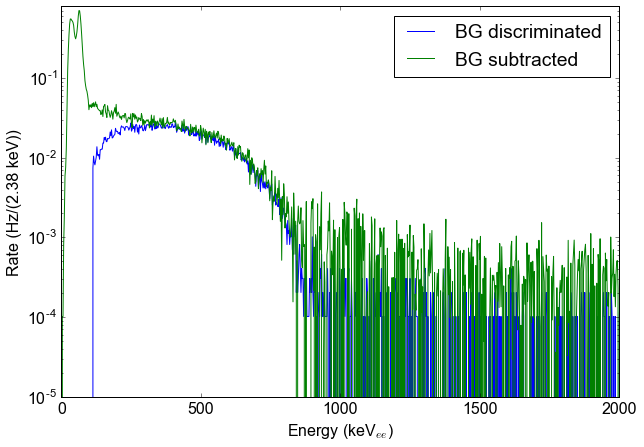

In [4]:
plt.plot(e_scale, fg_0_disc, label='BG discriminated')
plt.plot(e_scale, fg_0_sub, label= 'BG subtracted')
plt.ylabel('Rate (Hz/(2.38 keV))')
plt.yscale('log')
plt.xlim(0,2000)
plt.ylim(0.00001, 0.8)
plt.xlabel('Energy (keV$_{ee}$)')
plt.legend()
plt.show()

In [5]:
from iminuit import Minuit

In [6]:
# Chi^2 function for single Gaussian function in neutron energy
class Chi2Func:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2
    
# Chi^2 function for two Gaussian functions in neutron energy
class Chi2Func_2:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated_2(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2    

### Settings for fits

In [7]:
min_e = 450
max_e = 800

### Fit background rejected spectrum

In [29]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_0_disc[sel]
y_err = fg_0_disc_err[sel]

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(a=0.3, mu=2.5, sigma=0.5, error_a = 1, error_mu = 1, error_sigma = 1, errordef=1)
# Initialize minimizer and minimize
m_sing_disc = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_sing_disc.migrad();
print(m_sing_disc.values)

FCN = 171.67195722440212 
 TOTAL NCALL = 85 
 NCALLS = 85 
 
 
 EDM = 4.499364191398817e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.303149,0.00434666,0,0,,,
2,mu,2.36241,0.00648631,0,0,,,
3,sigma,0.210501,0.00997483,0,0,,,


{'a': 0.30314874314457996, 'sigma': 0.21050103106450066, 'mu': 2.362412170636078}


The following cell is depricated. It is to fit a double Gaussian where one is a high-energy component due to 14 MeV neutrons

In [30]:
# # Select the data to fit
# sel = (x3 > 450) & (x3 < 2000)
# x = x3[sel]
# y_data = f3[sel]
# y_err = f3_err[sel]

# # Initialize chi2 function
# chi2 = Chi2FuncFull(x, y_data, y_err)

# # Give guess parameters
# my_args = dict(
#     a1=281, mu1=2.36, sigma1=0.196, error_a1 = 0.1, error_mu1 = 0.1, error_sigma1 = 0.01,
#     a2=79, mu2=16.2, sigma2=0.4, error_a2 = 0.1, error_mu2 = 0.1, error_sigma2 = 0.1)
# # Initialize minimizer and minimize
# m3 = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
# m3.migrad();
# print(m3.values)

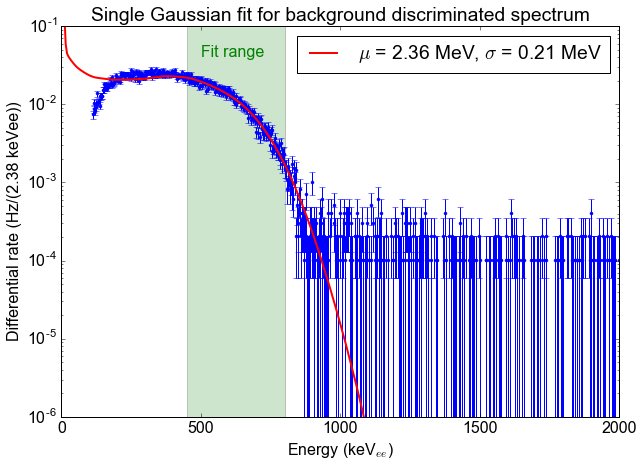

In [32]:
vals = m_sing_disc.values
plt.errorbar(e_scale, fg_0_disc, fg_0_disc_err, ls='None', marker='.')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, **vals), color='red', lw=2,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu'], vals['sigma']))

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,1e-1)
plt.xlim(0,2000)
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Single Gaussian fit for background discriminated spectrum')
#plt.savefig('07_fit_spectrum.pdf', bbox_inches='tight')
plt.show()

### Fit spectrum for BG subtracted spectrum

We can play the same trick for the spectrum where we subtract background.

In [34]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_0_sub[sel]
y_err = fg_0_sub_err[sel]
assert len(fg_0_sub_err[sel][fg_0_sub_err[sel] == 0]) == 0

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a=0.3, mu=2.4, sigma=0.196, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1)

# m: minimizer; sing: single Gaussian; sub: subtracted the background
m_sing_sub = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_sing_sub.migrad();
print(m_sing_sub.values)

FCN = 156.15593723705916 
 TOTAL NCALL = 60 
 NCALLS = 60 
 
 
 EDM = 5.365038087424724e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.327686,0.00699991,0,0,,,
2,mu,2.38351,0.0100449,0,0,,,
3,sigma,0.208683,0.018555,0,0,,,


{'a': 0.32768574265747824, 'sigma': 0.20868268551661187, 'mu': 2.3835121946671403}


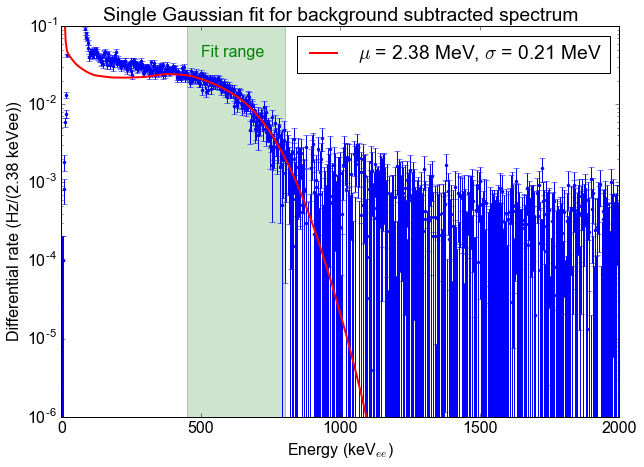

In [35]:
vals = m_sing_sub.values
plt.errorbar(e_scale, fg_0_sub, fg_0_sub_err, ls='None', marker='.')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, **vals), color='red', lw=2,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu'], vals['sigma']))

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,1e-1)
plt.xlim(0,2000)
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Single Gaussian fit for background subtracted spectrum')
#plt.savefig('07_fit_spectrum.pdf', bbox_inches='tight')
plt.show()

### Fit double Gaussian

In [ ]:
# Settings

In [36]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_0_sub[sel]
y_err = fg_0_sub_err[sel]
assert len(fg_0_sub_err[sel][fg_0_sub_err[sel] == 0]) == 0

# Initialize chi2 function
chi2 = Chi2Func_2(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a1=0.04, mu1=2.2, sigma1=0.1, error_a1 = 0.0001, error_mu1 = 0.1, error_sigma1 = 0.01,
    a2=0.04, mu2=2.6, sigma2=0.1, error_a2 = 0.0001, error_mu2 = 0.1, error_sigma2 = 0.01,
    errordef=1)
# Initialize minimizer and minimize
m_doub_sub = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
m_doub_sub.migrad();
print(m_doub_sub.values)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:16: InitialParamWarning: errordef is not given. Default to 1.


FCN = 148.58766279097526 
 TOTAL NCALL = 720 
 NCALLS = 720 
 
 
 EDM = 4.604429040000161e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a1,0.186875,0.119067,0,0,,,
2,mu1,2.52409,0.142242,0,0,,,
3,sigma1,0.159594,0.129717,0,0,,,
4,a2,0.134074,0.116934,0,0,,,
5,mu2,2.22995,0.0493754,0,0,,,
6,sigma2,0.0648363,0.0575086,0,0,,,


{'sigma2': 0.06483625708895463, 'mu2': 2.2299517095298818, 'sigma1': 0.15959427414255467, 'a1': 0.18687529330043062, 'a2': 0.13407448576664707, 'mu1': 2.5240903466337294}


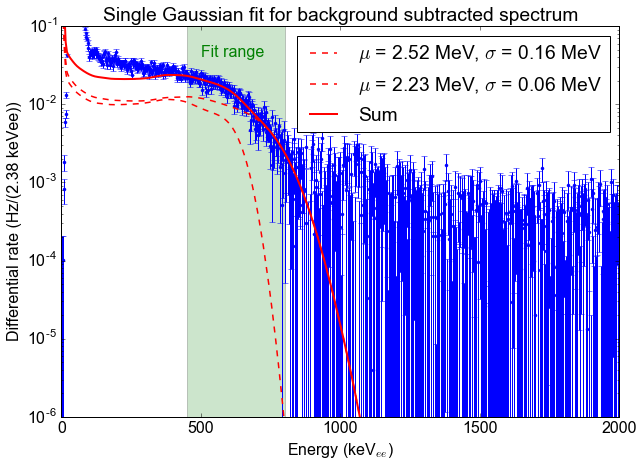

In [41]:
vals = m_doub_sub.values
plt.errorbar(e_scale, fg_0_sub, fg_0_sub_err, ls='None', marker='.')
# Take subplots
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals['a1'], vals['mu1'], vals['sigma1']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu1'], vals['sigma1']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals['a2'], vals['mu2'], vals['sigma2']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu2'], vals['sigma2']), ls='--')

plt.plot(e_scale, get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum')

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,1e-1)
plt.xlim(0,2000)
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Double Gaussian fit for background subtracted spectrum')
#plt.savefig('07_fit_spectrum.pdf', bbox_inches='tight')
plt.show()

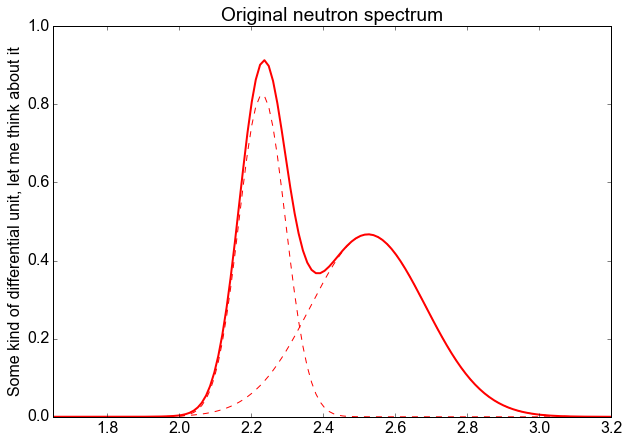

In [45]:
vals = m_doub_sub.values
plt.plot(neutron_energies, vals['a1']*gaussian(neutron_energies, vals['mu1'],vals['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals['a2']*gaussian(neutron_energies, vals['mu2'],vals['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, vals['a1']*gaussian(neutron_energies, vals['mu1'],vals['sigma1']) +
         vals['a2']*gaussian(neutron_energies, vals['mu2'],vals['sigma2']),c='red',lw=2)
plt.xlim(1.65, 3.2)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

### High energy population

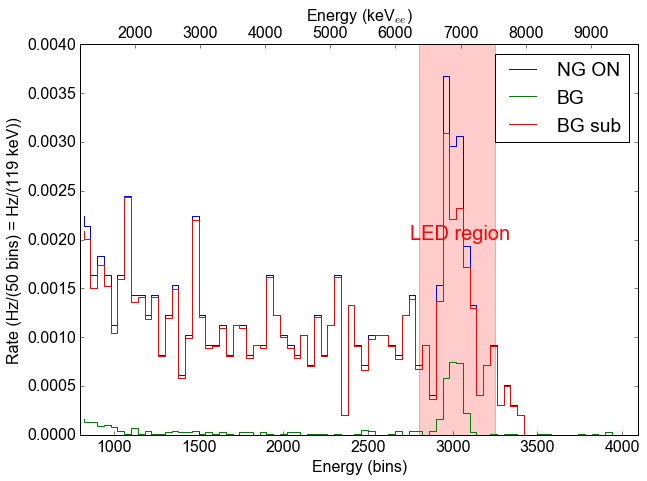

In [46]:
# Build histograms
entries_ng, bins_e  = np.histogram(entries_high,bins=80, range=(800,4000))
entries_bg, bins_e  = np.histogram(entries_high_bg,bins=80, range=(800,4000))

# Use bin centers
bins_e_centers = 0.5*(bins_e[:-1] + bins_e[1:])

# Plot all
plt.plot(bins_e_centers,1/ng_livetimes_0[0]*entries_ng,linestyle='steps',label='NG ON')
plt.plot(bins_e_centers,1/sum(bg_livetimes_0)*entries_bg,linestyle='steps',label='BG')
plt.plot(bins_e_centers,1/ng_livetimes_0[0]*entries_ng - 1/sum(bg_livetimes_0)*entries_bg,linestyle='steps',label='BG sub')

draw_box((2800,3250),(0,0.0040), facecolor='red', alpha=0.2)
plt.ylim(0,0.0040)
plt.xlim(800,4095)
plt.xlabel('Energy (bins)')
plt.ylabel('Rate (Hz/(50 bins) = Hz/(119 keV))')
plt.legend()
plt.text(2750,0.002, 'LED region', color='red', fontsize=20)

# Make a second x axis that shows the actual energy in keVee
plt.twiny()
plt.xlim(e_scale[500], e_scale[4095])
plt.xlabel('Energy (keV$_{ee}$)')
plt.show()

In [47]:
# //finally// convert bins to keV
e_scale_he = np.array([poly_1(x, *p_scale_to_e) for x in bins_e_centers])

In [48]:
mask = ((bins_e_centers < 2800) | (bins_e_centers > 3200))
x = e_scale_he[mask]

y_data = 1/ng_livetimes_0[0]*entries_ng - 1/sum(bg_livetimes_0)*entries_bg
y_data = y_data[mask]
y_err = 1/ng_livetimes_0[0]*np.sqrt(entries_ng) # neglect BG errors
# Set errors to one if entry is zero
for i, ye in enumerate(y_err):
    if ye==0:
        y_err[i] = 1/ng_livetimes_0[0]*1.
y_err = y_err[mask]

In [49]:
chi2 = Chi2Func(x, y_data, y_err)

In [54]:
# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a=0.4, mu=14, sigma=1., error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1)
# Initialize minimizer and minimize
m_high = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_high.migrad();
print(m_high.values)

FCN = 81.85192146971796 
 TOTAL NCALL = 103 
 NCALLS = 103 
 
 
 EDM = 5.349710003649126e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.562643,0.0251192,0,0,,,
2,mu,13.9929,0.0935605,0,0,,,
3,sigma,0.253862,0.132643,0,0,,,


{'a': 0.5626431862672487, 'sigma': 0.25386184090908076, 'mu': 13.99286537210304}


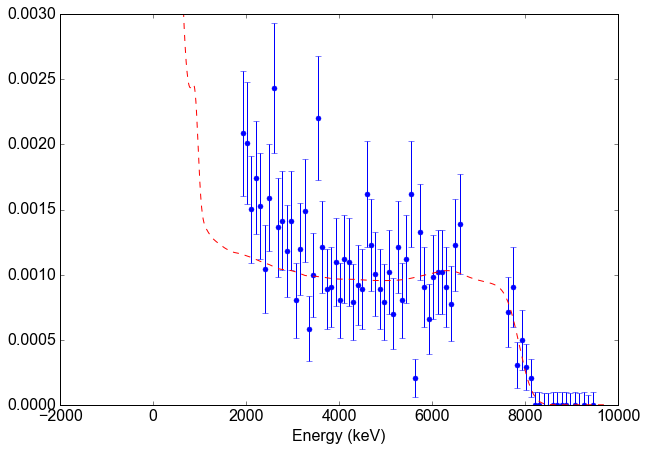

In [56]:
plt.errorbar(x, y_data, y_err, ls='None', marker='.', markersize = 10)
#plt.xlim(800,4500)
plt.ylim(0,0.003)
plt.xlabel('Energy (keV)')
plt.plot(e_scale, 
         get_neutron_spectrum_interpolated(e_scale, m_high.values['a'], m_high.values['mu'], m_high.values['sigma']),
         color='red',ls='--')


### Combine EVERYTHING

In [101]:
def rebin(arr, factor=2, mode='avg'):
    if mode == 'avg':
        rebin = np.array([1/factor*sum(arr[i:i + factor]) for i in np.arange(0, len(arr), factor)])
    elif mode == 'sum':
        rebin = np.array([sum(arr[i:i + factor]) for i in np.arange(0, len(arr), factor)])
    elif mode == 'quad':
        rebin = np.array([np.sqrt(sum(arr[i:i + factor]**2))
                          for i in np.arange(0, len(arr), factor)])
    elif mode == 'quad_avg':
        rebin = np.array([1/factor*np.sqrt(sum(arr[i:i + factor]**2))
                          for i in np.arange(0, len(arr), factor)])
    else:
        raise SyntaxError('Did not get the rebinning mode, you specified: %s' % mode)
    
    return rebin

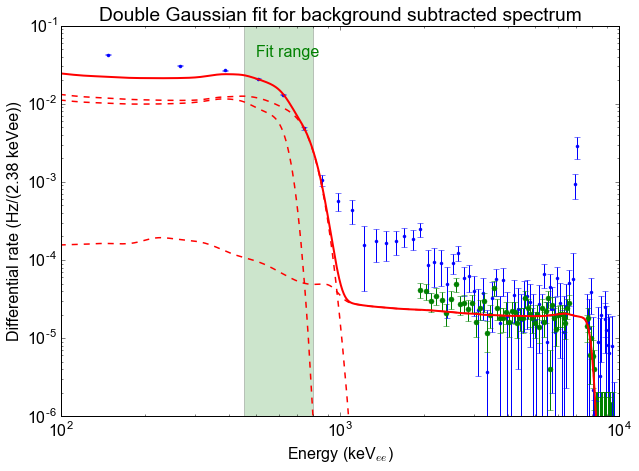

In [117]:
rebin_fac = 50

vals1 = m_doub_sub.values
vals2 = m_high.values

# Data (rebinned)
plt.errorbar(rebin(e_scale,rebin_fac), rebin(fg_0_sub,rebin_fac), rebin(fg_0_sub_err,rebin_fac, mode='quad_avg'),
             ls='None', marker='.', label='Background subtracted')
# High energy data
plt.errorbar(x, 0.02*y_data, 0.02*y_err, ls='None', marker='.', markersize = 10, label='High energy BG rejection')

# Subplots (3 contributions)
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals1['a1'], vals1['mu1'], vals1['sigma1']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals1['mu1'], vals1['sigma1']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals1['a2'], vals1['mu2'], vals1['sigma2']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals1['mu2'], vals1['sigma2']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, 0.02*vals2['a'], vals2['mu'], vals2['sigma']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals2['mu'], vals2['sigma']), ls='--')

# Full fit
plt.plot(e_scale, get_neutron_spectrum_interpolated_3(e_scale,
                                                     vals1['a1'], vals1['mu1'], vals1['sigma1'],
                                                     vals1['a2'], vals1['mu2'], vals1['sigma2'],
                                                     0.02*vals2['a'], vals2['mu'], vals2['sigma'], 
                                                     ), color='red', lw=2,
        label='Sum')

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,1e-1)
#plt.xlim(0,9000)
plt.xscale('log')
plt.xlim(100.,1e4)
#plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Double Gaussian fit for background subtracted spectrum')
plt.show()

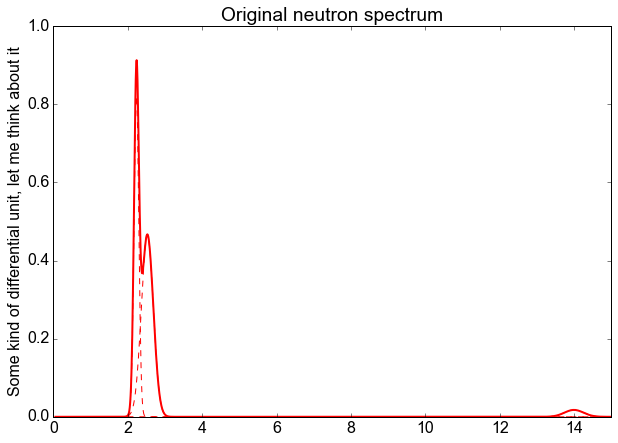

In [144]:
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')

plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         
         ,c='red',lw=2)
plt.xlim(0, 15)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

In [130]:
def int_spec(x, y):
    '''
    Integrate spectrum
    '''
    dx = np.diff(x)
    return sum(y[:-1]*dx)

In [135]:
int_gauss1 = int_spec(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']))
int_gauss2 = int_spec(neutron_energies,vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']))
int_gauss3 = int_spec(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']))
int_tot = int_gauss1 + int_gauss2 + int_gauss3

In [137]:
print('Totals: %.1f%% at %.2f MeV; %.1f%% at %.2f MeV; %.1f%% at %.2f MeV' % 
      (int_gauss1/int_tot*100, vals1['mu1'],
      int_gauss2/int_tot*100, vals1['mu2'],
       int_gauss3/int_tot*100, vals2['mu'],
      ))

Totals: 56.3% at 2.52 MeV; 40.4% at 2.23 MeV; 3.4% at 13.99 MeV
